# EDA 

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import glob
import seaborn as sns
import urllib.request

plt.style.use('ggplot')

DATA_PATH = 'data/'

In [50]:
# defining the categories to use
# to use the full dataset, list all files in the data directory
classes = [
    'apple', 'bicycle', 'car', 'cat', 'cloud', 'eye', 'pizza', 'star', 'tree', 'umbrella',
    'airplane', 'banana', 'book', 'butterfly', 'camera', 'cup', 'door', 'flower', 'sun', 't-shirt'
]

# creating the data directory
os.makedirs('data', exist_ok=True)
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

print(f"Targeting {len(classes)} classes.")

# downloading missing data
print("Checking data...")
for c in classes:
    path = f'data/{c}.npy'
    if not os.path.exists(path):
        print(f'Downloading {c}...')
        urllib.request.urlretrieve(f'{base_url}{c}.npy', path)

print("All data is ready.")

Targeting 20 classes.
Checking data...
All data is ready.


In [51]:
# loading the apple dataset to inspecting its structure
apple_data = np.load('data/apple.npy')

print(f"Raw shape: {apple_data.shape}")
print(f"Min pixel value: {apple_data.min()}")
print(f"Max pixel value: {apple_data.max()}")
print(f"Data type: {apple_data.dtype}")

Raw shape: (144722, 784)
Min pixel value: 0
Max pixel value: 255
Data type: uint8


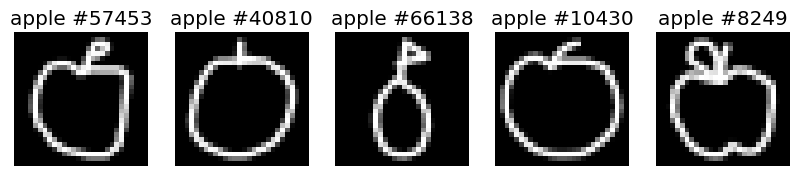

In [52]:
def plot_samples(category, n=5):
    data = np.load(f'data/{category}.npy')
    
    # Randomly picking 'n' indices
    indices = np.random.randint(0, len(data), size=n)
    
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        # Reshaping 784 -> 28x28 image
        img = data[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{category} #{idx}")
    plt.show()

plot_samples('apple')

In [53]:
files = glob.glob('data/*.npy')

counts = {}
for f in files:
    # using mmap to avoid reading entire file into memory
    data = np.load(f, mmap_mode='r') 
    name = f.split('/')[-1].replace('.npy', '')
    counts[name] = len(data)

# visualizing class distribution
df_counts = pd.DataFrame(list(counts.items()), columns=['Category', 'Count'])
fig = px.bar(df_counts, x='Category', y='Count', title="Number of Images per Category", text='Count')
fig.show()

print(f"Min samples: {min(counts.values())}")
print(f"Max samples: {max(counts.values())}")

Min samples: 117999
Max samples: 307936


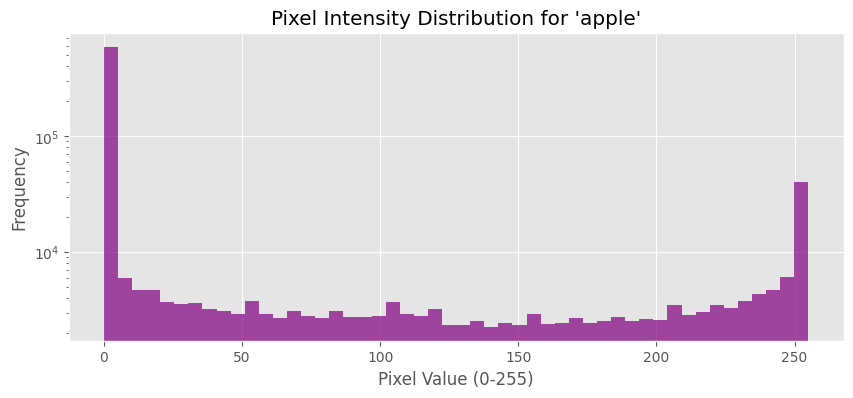

In [54]:
def check_pixel_distribution(category):
    data = np.load(f'data/{category}.npy')
    
    # Flattening all pixels from the first 1000 images into one big list
    all_pixels = data[:1000].flatten()
    
    plt.figure(figsize=(10, 4))
    
    plt.hist(all_pixels, bins=50, color='purple', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution for '{category}'")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.yscale('log') # Log scale because 0 (background) is huge
    plt.show()

check_pixel_distribution('apple')

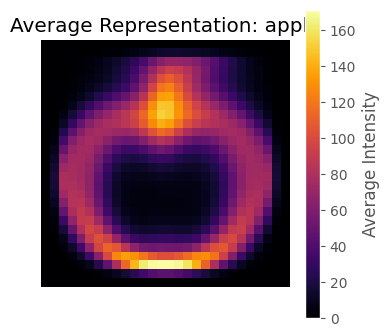

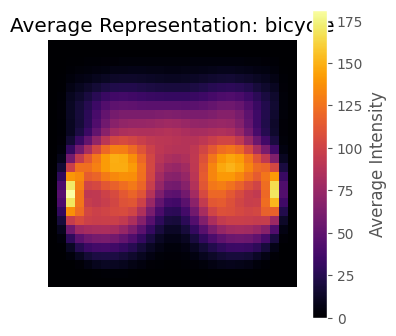

In [55]:
def plot_average_image(category):
    data = np.load(f'data/{category}.npy')
    
    mean_img = data.mean(axis=0).reshape(28, 28)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(mean_img, cmap='inferno') 
    plt.title(f"Average Representation: {category}")
    plt.axis('off')
    plt.colorbar(label='Average Intensity')
    plt.show()

plot_average_image('apple') 
plot_average_image('bicycle')

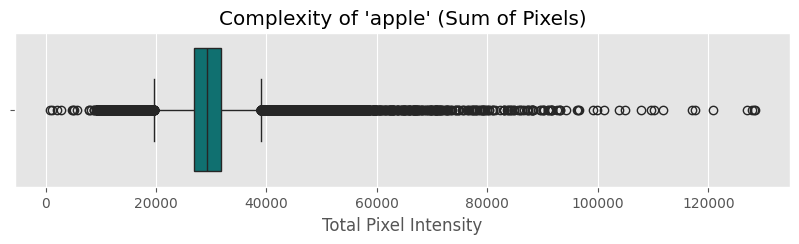

Found 1 suspicious/empty drawings.


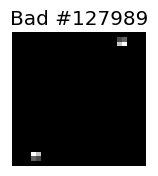

In [56]:
def find_outliers(category):
    data = np.load(f'data/{category}.npy')
    
    # calculating pixel sum for each image
    pixel_sums = data.sum(axis=1)
    
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=pixel_sums, color='teal')
    plt.title(f"Complexity of '{category}' (Sum of Pixels)")
    plt.xlabel("Total Pixel Intensity")
    plt.show()
    
    # checking for empty or near-empty drawings
    empty_indices = np.where(pixel_sums < 1000)[0]
    
    if len(empty_indices) > 0:
        print(f"Found {len(empty_indices)} suspicious/empty drawings.")
        plt.figure(figsize=(10, 2))
        for i, idx in enumerate(empty_indices[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(data[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f"Bad #{idx}")
        plt.show()
    else:
        print("No empty drawings found.")

find_outliers('apple')

## Data Prep
We need to get the data ready for the model. We'll limit it to 5k samples per class so it fits in memory, normalize the pixels, and split it into train/test sets.

In [57]:
from sklearn.model_selection import train_test_split

# verifying available data on disk
available_classes = [c for c in classes if os.path.exists(f'data/{c}.npy')]

# mapping class names to integers
class_to_idx = {class_name: idx for idx, class_name in enumerate(available_classes)}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
print(f"Class mappings defined for {len(available_classes)} classes.")

# limiting samples for efficient processing
# adjust this based on available system memory
MAX_SAMPLES_PER_CLASS = 5000 
TEST_SIZE = 0.2

X_data = []
y_data = []

print(f"Loading up to {MAX_SAMPLES_PER_CLASS} samples per class...")

for category in available_classes:
    path = f'data/{category}.npy'
    data = np.load(path)
        
    # subsampling to manage memory usage
    data = data[:MAX_SAMPLES_PER_CLASS]
    
    # normalizing pixel values to 0-1 range
    data = data.astype('float32') / 255.0
    
    # creating labels
    label = class_to_idx[category]
    labels = np.full(len(data), label)
    
    X_data.append(data)
    y_data.append(labels)

# concatenating all data arrays
X = np.concatenate(X_data, axis=0)
y = np.concatenate(y_data, axis=0)

print(f"Total Dataset: X={X.shape}, y={y.shape}")

# splitting into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

Class mappings defined for 20 classes.
Loading up to 5000 samples per class...
Total Dataset: X=(100000, 784), y=(100000,)
Train: X=(80000, 784), y=(80000,)
Test:  X=(20000, 784), y=(20000,)


## Model Training
We train a Convolutional Neural Network (CNN), utilizing a dropout layer to improve generalization. A hyperparameter search finds the best configuration.

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# checking for gpu availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# reshaping data for cnn input (batch, 28, 28, 1)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

print(f"CNN input shape: {X_train_cnn.shape}")

Num GPUs Available:  1
CNN input shape: (80000, 28, 28, 1)


In [59]:
def build_model(num_classes, learning_rate=0.001, dropout_rate=0.3, dense_units=128, start_filters=32):
    model = models.Sequential([
        # convolutional block 1
        layers.Conv2D(start_filters, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # convolutional block 2
        layers.Conv2D(start_filters * 2, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # convolutional block 3
        layers.Conv2D(start_filters * 2, (3, 3), activation='relu'),
        
        # dense layers
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate), 
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# early stopping configuration
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

In [60]:
import itertools

# defining hyperparameter search space
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [128, 256]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Testing {len(combinations)} model configurations.")

best_acc = 0
best_model = None
best_params = {}
history_best = None

# executing grid search
for params in combinations:
    print(f"\nTraining params: {params}")
    
    model = build_model(
        num_classes=len(available_classes),
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        dense_units=params['dense_units']
    )
    
    history = model.fit(
        X_train_cnn, y_train,
        epochs=12, 
        batch_size=256,
        validation_data=(X_test_cnn, y_test),
        callbacks=[early_stopping],
        verbose=0 
    )
    
    val_acc = max(history.history['val_accuracy'])
    print(f" -> Val Accuracy: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_params = params
        history_best = history
        print(" -> New Best Model")

print(f"\nTraining Complete.")
print(f"Best Params: {best_params}")
print(f"Best Accuracy: {best_acc:.4f}")

Testing 8 model configurations.

Training params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 128}


/home/manu/miniconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 -> Val Accuracy: 0.9257
 -> New Best Model

Training params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 256}
 -> Val Accuracy: 0.9008

Training params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 128}
 -> Val Accuracy: 0.8905

Training params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 256}
 -> Val Accuracy: 0.8912

Training params: {'learning_rate': 0.0005, 'dropout_rate': 0.3, 'dense_units': 128}
 -> Val Accuracy: 0.8787

Training params: {'learning_rate': 0.0005, 'dropout_rate': 0.3, 'dense_units': 256}
 -> Val Accuracy: 0.8691

Training params: {'learning_rate': 0.0005, 'dropout_rate': 0.5, 'dense_units': 128}
 -> Val Accuracy: 0.8644

Training params: {'learning_rate': 0.0005, 'dropout_rate': 0.5, 'dense_units': 256}
 -> Val Accuracy: 0.8746

Training Complete.
Best Params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 128}
Best Accuracy: 0.9257


## Evaluation
We evaluate the final model's performance on the test set.

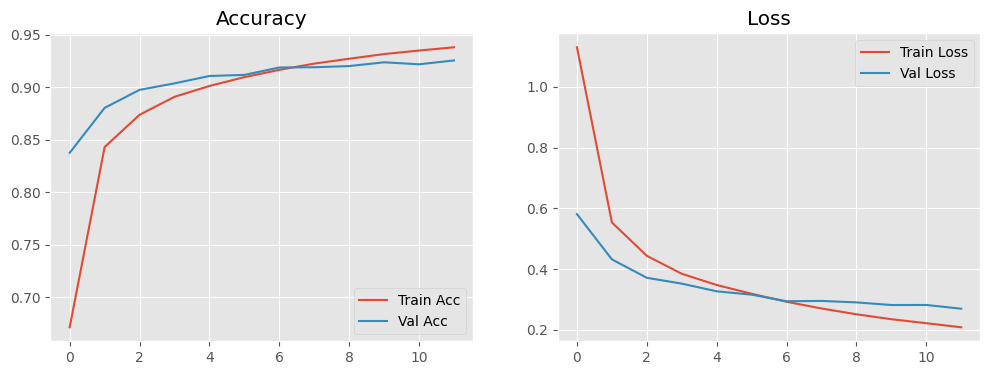

In [61]:
# plotting the training history of the best run
acc = history_best.history['accuracy']
val_acc = history_best.history['val_accuracy']
loss = history_best.history['loss']
val_loss = history_best.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
              precision    recall  f1-score   support

       apple       0.97      0.96      0.96      1000
     bicycle       0.95      0.94      0.94      1000
         car       0.91      0.94      0.93      1000
         cat       0.85      0.89      0.87      1000
       cloud       0.89      0.94      0.91      1000
         eye       0.95      0.90      0.92      1000
       pizza       0.94      0.90      0.92      1000
        star       0.92      0.89      0.91      1000
        tree       0.92      0.95      0.93      1000
    umbrella       0.95      0.94      0.95      1000
    airplane       0.87      0.92      0.89      1000
      banana       0.94      0.95      0.95      1000
        book       0.87      0.93      0.90      1000
   butterfly       0.96      0.92      0.93      1000
      camera       0.95      0.95      0.95      1000
         cup       0.89      0.88      0.88      1000
        door       0.95      0.94     

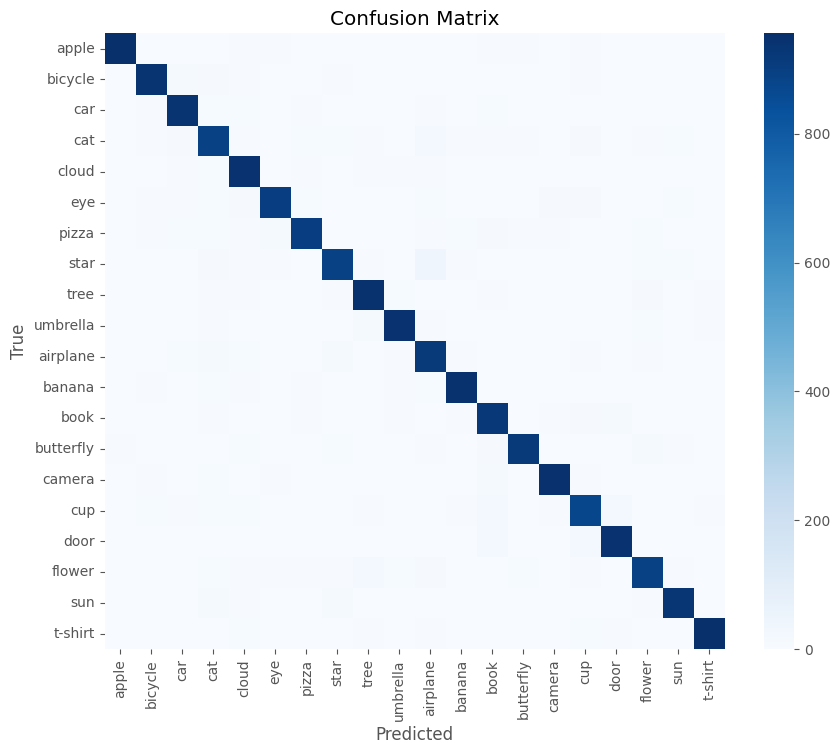

Best model saved to doodle_cnn_best.h5


In [62]:
from sklearn.metrics import classification_report, confusion_matrix

# generating predictions on the test set
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=classes))

# visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# saving the best model to disk
best_model.save('doodle_cnn_best.h5')
print("Best model saved to doodle_cnn_best.h5")